# Overview
This notebook will examine quantitative 7T MRI measures projected onto hippocampal midthickness surfaces and averaged across 10 subjects. At the end, we will combine this with Histology data and examine conserved features

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import scipy
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob
sys.path.insert(1, '/export03/data/opt/Hippo_Spin_Testing')
from hippo_spin_testing import spin_test


In [14]:
micapipe_dir = '../sourcedata/Supersession_PNI'
hippunfold_dir = '../hippunfold/PNI_v1.3.0_super/hippunfold'

subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC016', 'PNC018', 'PNC019']
ses = ''
hemis = ['L','R']
labels = ['hipp','dentate'] 

# here we will generate multiple depth-wise surfaces
layers = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(layers>=0,  layers <=1))[0]
ind = [range(7262), range(7262,7262+1788)]

In [15]:
features = ['qT1','MTR','T2star','FA','ADC']
for s,sub in enumerate(subs):
    cmd = f'mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths'
    !{cmd}
    for h,hemi in enumerate(hemis):
        for l,layer in enumerate(layers):
            if not glob.glob(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii'):
                cmd1 = f'wb_command -surface-cortex-layer '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_inner.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_outer.surf.gii '\
                    f'{layer} '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii'
                !{cmd1}
            for f,feature in enumerate(features):
                if not glob.glob(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii'):
                    cmd2 = f'wb_command -volume-to-surface-mapping '\
                        f'{micapipe_dir}/sub-{sub}/anat/sub-{sub}_space-nativepro_{feature}.nii.gz '\
                        f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii '\
                        f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii '\
                        f'-trilinear'
                    !{cmd2}

In [16]:
hipp_dat = np.zeros([7262,2,len(subs),len(layers),len(features)])*np.nan

for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        for h,hemi in enumerate(hemis):
            for l,layer in enumerate(layers):
                try:
                    d = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii')
                    hipp_dat[:,h,s,l,f] = d.darrays[0].data
                except:
                    print(f'sub-{sub}_{hemi}_{feature} not found')

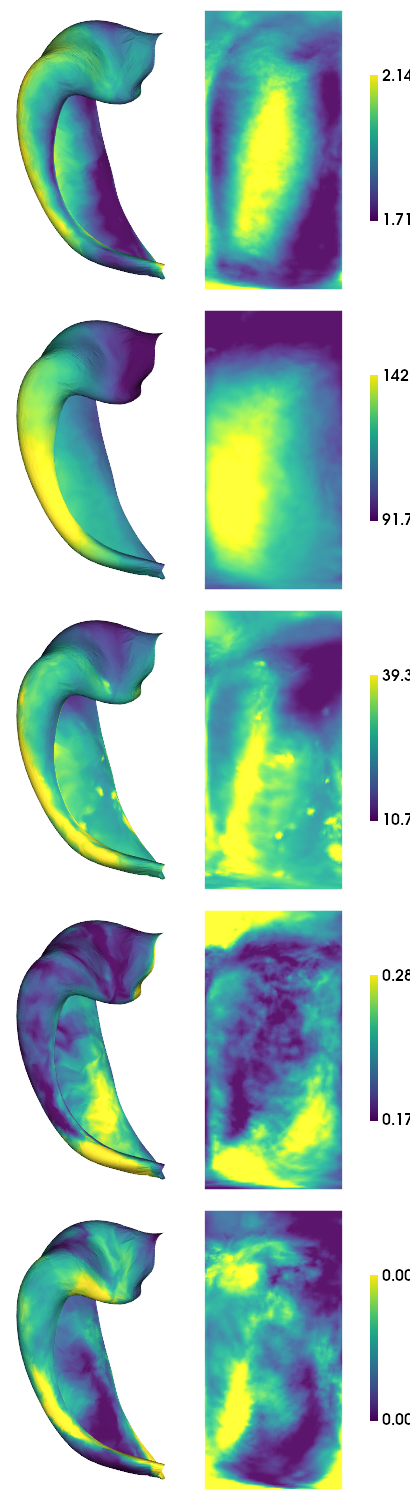

In [17]:
cdata = np.nanmean(hipp_dat,axis=(1,2))
plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,:],axis=1), color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

In [18]:
!mkdir img_struct
for i in range(5):
    plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,i],axis=1), labels=['hipp'], color_bar=('right'), hemis=['L'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename=f'img_struct/{i}.png')

mkdir: cannot create directory ‘img_struct’: File exists


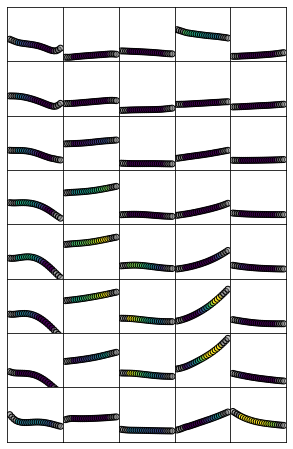

In [19]:
# let's look at some laminar profiles (Ant to Post)
nsamp=8
sampAP = np.linspace(0,254,nsamp+1).astype('int') #NOTE: here we cut off the 20% anterior and posterior since they show a lot of noise!

fig, ax = plt.subplots(nrows=nsamp, ncols=len(features), figsize=(1*len(features),1*nsamp))
for s in range(len(features)):
    
    cdat,_,_ = utils.density_interp('0p5mm','unfoldiso',cdata[:,:,s],label='hipp')
    cdat = np.reshape(scipy.stats.zscore(cdat,axis=None),[126,254,25])
    l = np.nanmean(cdat[:,:,gm],axis=2).flatten()
    # l = utils.bound_cdata(l)
    lims = [min(l)-.1, max(l)+.1]
    
    for i in range(nsamp):
        dat = np.nanmean(cdat[:,sampAP[i]:sampAP[i+1],:],axis=(0,1))
        col = plt.cm.viridis(dat)
        col[:,:][layers<0] = 0.5
        col[:,:][layers>1] = 0.5
        ax[i,s].scatter(layers,dat, c=col, edgecolors='black')
        ax[i,s].set_ylim(lims)
        # ax[i,s].axis('off')
        ax[i,s].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)

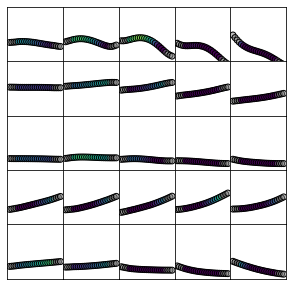

In [20]:
# let's look at some laminar profiles (Prox to Dist)
nsamp=5
sampPD = np.linspace(0,126,nsamp+1).astype('int')

fig, ax = plt.subplots(nrows=len(features), ncols=nsamp, figsize=(1*nsamp,1*len(features)))
for s in range(len(features)):
    
    cdat,_,_ = utils.density_interp('0p5mm','unfoldiso',cdata[:,:,s],label='hipp')
    cdat = np.reshape(scipy.stats.zscore(cdat,axis=None),[126,254,25])
    l = np.nanmean(cdat[:,:,gm],axis=2).flatten()
    # l = utils.bound_cdata(l)
    lims = [min(l)-.1, max(l)+.1]
    
    for i in range(nsamp):
        dat = np.nanmean(cdat[sampPD[i]:sampPD[i+1],:,:],axis=(0,1))
        col = plt.cm.viridis(dat)
        col[:,:][layers<0] = 0.5
        col[:,:][layers>1] = 0.5
        ax[s,nsamp-i-1].scatter(layers,dat, c=col, edgecolors='black')
        ax[s,nsamp-i-1].set_ylim(lims)
        # ax[s,nsamp-i-1].axis('off')
        ax[s,nsamp-i-1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)

In [21]:
cdata.shape

(7262, 25, 5)

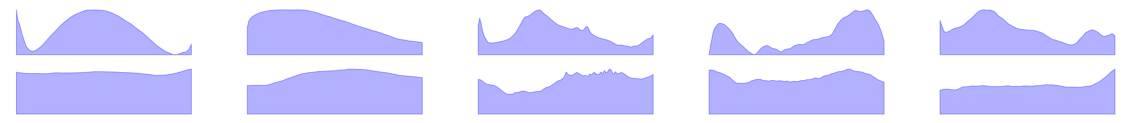

In [30]:
from scipy.ndimage import gaussian_filter1d
fig, ax = plt.subplots(nrows=2, ncols=len(features), figsize=(4*len(features),2))
for s in range(len(features)):
    resampled_data,_,_ = utils.density_interp('0p5mm','unfoldiso',np.nanmean(cdata[:,gm,s],axis=1), label='hipp')
    resampled_data = np.reshape(resampled_data,(126,254))
    datPD = np.nanmean(resampled_data[:,100:-100][::-1],axis=1) # cuts of AP edges
    datAP = np.nanmean(resampled_data,axis=0)
    # normalize
    datPD = datPD - np.min(np.concatenate([datPD, datAP]))
    datAP = datAP - np.min(np.concatenate([datPD, datAP]))
    # datPD = datPD / np.max(np.concatenate([datPD, datAP]))
    # datAP = datAP / np.max(np.concatenate([datPD, datAP]))
    # plot
    ax[0,s].fill_between(range(126),datPD,0,color='b', alpha=.3)
    # ax[0,s].set_ylim([0,1])    
    ax[0,s].axis('off')
    ax[1,s].fill_between(range(254),datAP,0,color='b', alpha=.3)
    # ax[1,s].set_ylim([0,1])    
    ax[1,s].axis('off')

## save

In [23]:
# save a copy including depths
np.save("../checkpoints/struct-PNI-averaged",cdata[:,gm,:])

In [24]:
# save 2D map
for f,feature in enumerate(features):
    cdat = np.nanmean(cdata[:,gm,f],axis=1).flatten()
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/MRI-7T-{feature}_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii')